# Antarctica: Probe Clusters

The Neighbor Graphs (02-neighbor-graphs.ipynb) experiment showed that there are a large number of unique solutions with similar scores, making it difficult to identify a clear winner.

We also saw that there are explicit groups of probes that fit well together. As long as we transpose the entire group, they fit equally well on either side of the diagonal. Can we use this to our advantage to minimize the time required to recover the probes?

# Setup

In [1]:
import random
from time import sleep
from typing import Mapping, NamedTuple, Sequence

import numpy as np
import pandas as pd
from pandas import Series
import seaborn as sns
from matplotlib import patches as patches
from matplotlib import pyplot as plt
from pandas import DataFrame
from tqdm import tqdm

import antarctica as aa

In [2]:
sns.set_style("whitegrid")

# Probe Clusters

Let's take a look at the neighbor graphs of length 5 again.

In [3]:
# Read in original probes data
probes = aa.create_probes("data/probes.csv")

# Catalog all locations
locations = aa.catalog_locations(probes)

# Create neighbor graph for every location
graphs = {}
for location_id in locations.index:
    graph, _ = aa.neighbor_graph(locations, location_id=location_id)
    graphs[location_id] = graph

graph_lengths = {location_id: len(graphs[location_id]) for location_id in graphs}

# Inspect 5-location graphs
selected = [graphs[k] for k, v in graph_lengths.items() if v == 5]
selected

[{44: 88.0, 88.0: 32.0, 32.0: 56.0, 56.0: 34.0, 34.0: 56.0},
 {45: 68.0, 68.0: 16.0, 16.0: 79.0, 79.0: 75.0, 75.0: 79.0},
 {94: 38.0, 38.0: 82.0, 82.0: 6.0, 6.0: 84.0, 84.0: 6.0},
 {95: 18.0, 18.0: 66.0, 66.0: 29.0, 29.0: 25.0, 25.0: 29.0}]

There are 4 5-location graphs but if we look closer we'll see there are 2 distinct groups of probes.

In [4]:
# Extract probes for selected graphs
clusters = []
for graph in selected:
    cluster = aa.neighbor_graph_probes(locations, graph=graph)
    if cluster in clusters:
        continue

    clusters.append(cluster)

clusters

[{6, 32, 34, 38, 44}, {16, 18, 25, 29, 45}]

There are two distinct groups of probes: {6, 32, 34, 38, 44} and {16, 18, 25, 29, 45}. 

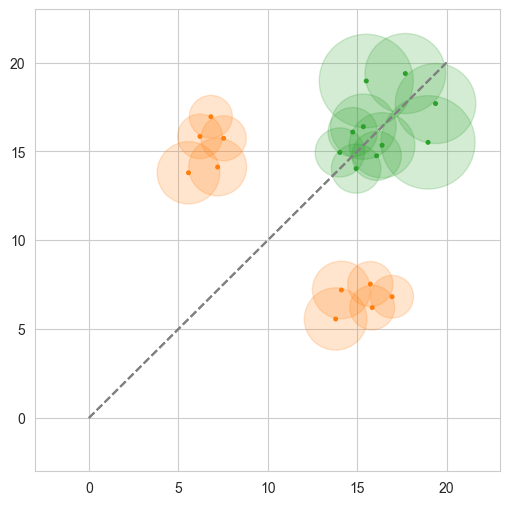

In [5]:
palette = sns.color_palette()

_, ax = plt.subplots(figsize=(6, 6))

for i, cluster in enumerate(clusters):
    df = locations[locations.probe_id.isin(cluster)]
    aa.plot.locations(df, highlight=df.index, highlight_color=palette[i+1], ax=ax)

This helps us understand where the 5-probe clusters are. But note the orange and green regions don't overlap. Let's say we confirm the top orange cluster is correct. This would rule out the bottom orange one but wouldn't have any effect on the green clusters.

Let's add a few more clusters.

In [6]:
# Inspect 4-location graphs
selected = [graphs[k] for k, v in graph_lengths.items() if v == 4]

# Extract probes for selected graphs
clusters4 = []
for graph in selected:
    cluster = aa.neighbor_graph_probes(locations, graph=graph)
    if cluster in clusters4:
        continue

    clusters4.append(cluster)
    
clusters4

[{1, 6, 12, 34},
 {16, 18, 25, 29},
 {2, 5, 11, 24},
 {5, 19, 27, 35},
 {7, 23, 30, 37},
 {6, 32, 34, 38}]

Lets add the top 2 to avoid overwhelming the visual.

In [7]:
clusters += clusters4[0:2]

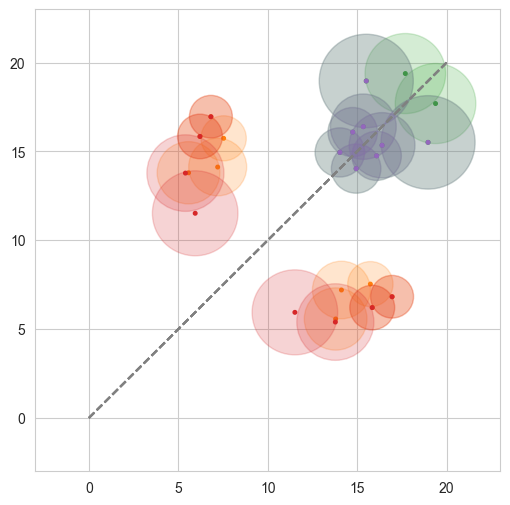

In [8]:
palette = sns.color_palette()

_, ax = plt.subplots(figsize=(6, 6))

for i, cluster in enumerate(clusters):
    df = locations[locations.probe_id.isin(cluster)]
    aa.plot.locations(df, highlight=df.index, highlight_color=palette[i+1], ax=ax)

We can already see the 4-probe clusters overlap with the 5-probe ones. This is encouraging because it suggests that selecting a 5-probe cluster should rule out a number of 4-probe clusters. This suggests that if we treat the probe recovery process as a decision tree, we may be able to significantly limit the number of holes we need to dig!

> *If we treat the probe recovery process as a decision tree, we may be able to significantly limit the number of holes we need to dig.*

The question is how many holes does each step remove?

# Estimating Probe Recovery

We saw in the Neighbor Graphs experiment that each graph we select modifies the graphs we have to choose from in the next iteration. In the analysis above, we provide a rationale that selecting a graph doesn't just change the graphs we have to choose from, it also dramatically reduces the number of locations we have left to explore.

Let's say we dig 1 test hole for each graph we select. A single hole should be enough to tell if the entire cluster of probes is on this side of the diagonal or not. If no probe is found at the test location, we should look for the entire cluster on the other side.

We should be able to simulate the process to estimate how many test holes we need on average to locate each cluster of probes. We can't just calculate it because it's not obvious how many graphs are ruled out by each selection.

The good news is we can simulate the process by tweaking the solution algorithm from the Neighbor Graphs experiment. In the cell below we run the same algorithm but instead of focusing on the final solution, we focus on how many steps it takes to get there.

In [9]:
n = 50
steps = []

# Iterate n times to estimate the variance
for _ in tqdm(range(n)):

    # Initialize candidates to all locations
    candidates = locations
    selected_locations = set()
    remaining_locations = []
    
    # Iterate multiple times an
    while candidates.probe_id.nunique() > 1:

        # Record number of locations left to choose from
        remaining_locations.append(len(candidates))
        
        # Create neighbor graphs for every candidate location
        graphs = {}
        for location_id in candidates.index:
            graphs[location_id] = aa.neighbor_graph(candidates, location_id=location_id)[0]
        
        # Record lengths
        df = DataFrame(
            [
                {
                    "location_id": location_id, 
                    "length": len(graphs[location_id]),
                }
                for location_id in graphs
            ]
        )
    
        # Keep only the largest graphs
        df = df[df.length == df.length.max()]
        
        # Randomly pick one to generate slightly different solutions each time
        location_id = df.location_id.sample().item()
        
        # Regenerate and record graph
        graph, remaining = aa.neighbor_graph(candidates, location_id=location_id)
    
        # Record selected locations
        selected_locations |= graph.keys()
    
        # Remove selected locations from candidates and repeat
        candidates = remaining[~remaining.index.isin(selected_locations)]

    # Record steps taken
    steps.append(len(remaining_locations))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Before we look at the steps, let's see how the number of remaining locations changed in the last run.

Text(0.5, 1.0, 'Remaining Locations')

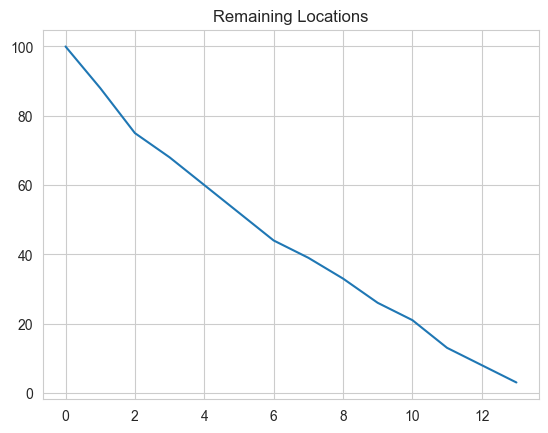

In [10]:
sns.lineplot(x=np.arange(len(remaining_locations)), y=remaining_locations)
plt.title("Remaining Locations")

We started with all 100 locations to choose from. With each iteration, the number of remaining locations drops quickly as we select clusters of probes and rule out others.

Let's see how many steps the process takes on average. This will serve as an estimate for the number of test holes required.

In [11]:
steps = Series(steps)

In [12]:
# Describe distribution
steps.describe()

count    50.000000
mean     14.000000
std       0.349927
min      13.000000
25%      14.000000
50%      14.000000
75%      14.000000
max      15.000000
dtype: float64

In [13]:
# Describe distribution in deciles instead of quartiles
steps.quantile(np.arange(0, 1.1, step=0.1))

0.0    13.0
0.1    14.0
0.2    14.0
0.3    14.0
0.4    14.0
0.5    14.0
0.6    14.0
0.7    14.0
0.8    14.0
0.9    14.0
1.0    15.0
dtype: float64

Over 50 runs the number of steps ranged from 13 to 15. Looking closer, over 70% of runs took exactly 14 steps, making 13 and 15 more like outliers.

# Summary

We saw how the probes naturally fall into clusters that all fit well within the expected nearest neighbor distance constraints. The larger the cluster, the more likely the locations are correct. However, the distance between probes doesn't change as long as we transpose the entire cluster. This means each cluster of probes fits just as well on either side of the diagonal. There is no way to know which side of the diagonal a cluster is on given the information we have.

That said, we should still be able to dramatically reduce the probe recovery time by recomputing the plan after digging each hole. The idea is to start with all 100 possible locations and test the clusters from largest to smallest. Choose either side of the diagonal and dig a test hole. If the probe is found, add all locations in the cluster to our confirmed list. If not, add the probes' alternate locations to our confirmed list. Remove any candidate locations that are ruled out by this choice. Repeat the process with the remaining candidates.

Following this process should require between 50 and 64 holes. If every test hole we dig is a hit, we'll only need 50 holes to recover all 50 probes. If every test hole we dig is a miss, we should need 14 test holes plus the 50 holes to recover the probes.